## CNN for 2D xy images

In [3]:
%matplotlib inline 
#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [4]:
import random            as random
import numpy             as np
import pandas            as pd
#import tables            as tb
import matplotlib.pyplot as plt
import os 

In [5]:
import xyimg.dataprep as dp
import xyimg.cnn      as cnn

In [6]:
path = os.environ['LPRDATADIR']+'xymm/'

pressure = '13bar'
coors  = ('x', 'y')
widths = (10, 10)
frame  = 100 
ifile = path + dp.xymm_filename(coors, widths, frame, prefix = 'xymm_'+pressure)
ofile = dp.prepend_filename(ifile, 'cnn')
print(ifile)
print(ofile)

/scratch/next/data/NEXT100/pressure_topology/xymm/xymm_13bar_xy_10x10_100.npz
/scratch/next/data/NEXT100/pressure_topology/xymm/cnn_xymm_13bar_xy_10x10_100.npz


## Test

In [7]:
path = os.environ['LPRDATADIR']+'xymm/'

pressure = '13bar'
coors  = ('x', 'y')
widths = (10, 10)
frame  = dp.frames[pressure]
ifile = path + dp.xymm_filename(coors, widths, frame, prefix = 'xymm_'+pressure)

cnn.test(ifile)

input filename  /scratch/next/data/NEXT100/pressure_topology/xymm/xymm_13bar_xy_10x10_100.npz
output filename  /scratch/next/data/NEXT100/pressure_topology/xymm/test_cnn_xymm_13bar_xy_10x10_100.npz
Dataset : 
   labels   : ['esum', 'emax', 'ecount']
   x shape  : (205612, 3, 10, 10)
   y shape  : (205612, 1)
   z labels : ['seg', 'ext']
   z shape  : (205612, 2, 10, 10)

Event Image tensor  (3, 10, 10)
CNN : 
   [200, 3, 10, 10] > [200, 6, 5, 5] > [200, 12, 3, 3] > [200, 24, 2, 2] > [200, 96] > [200, 6]
 > [200, 1]

Epoch:  train 0.033 +- 0.056  validation 0.011 +- 0.003
Epoch:  train 0.007 +- 0.003  validation 0.005 +- 0.002
Epoch:  train 0.004 +- 0.002  validation 0.003 +- 0.002
Epoch:  train 0.002 +- 0.001  validation 0.002 +- 0.001
Test  accuracy 99.93
save cnn results at  /scratch/next/data/NEXT100/pressure_topology/xymm/test_cnn_xymm_13bar_xy_10x10_100.npz


True

In [109]:
def production(ipath, opath, pressure, coors, widths, frame, labels, nepochs = 20, name = 'cnn', rejection = 0.95):

    ifile   = dp.xymm_filename(coors, widths, frame, 'xymm_'+pressure)
    ofile   = dp.prepend_filename(ifile, name)
    Dset    = cnn.GoDataset3DImg if len(coors) == 3 else cnn.GoDataset  
    dataset = Dset(ipath + ifile, labels)
    box     = cnn.run(dataset, ofilename = opath + ofile, nepochs = nepochs)
    print('efficiency {:2.1f}% at 80% rejection'.format(100.*cnn.roc_value(box.y, box.yp, rejection)[1]))
    return box, ifile, ofile


In [128]:
ipath = os.environ['LPRDATADIR']+'xymm/'
opath = 'temp/'

pressure = '13bar'
coors  = ('x', 'y')
widths = (10, 10)
frame  = dp.frames[pressure]
labels = ['ecount',]

box, ifile, ofile = production(ipath, opath, pressure, coors, widths, frame, labels, name = 'cnn_esum')


Dataset : 
   labels   : ['ecount']
   x shape  : (205612, 1, 10, 10)
   y shape  : (205612, 1)
   z labels : ['seg', 'ext']
   z shape  : (205612, 2, 10, 10)

Event Image tensor  (1, 10, 10)
CNN : 
   [200, 1, 10, 10] > [200, 2, 5, 5] > [200, 4, 3, 3] > [200, 8, 2, 2] > [200, 32] > [200, 2]
 > [200, 1]

Epoch:  train 0.127 +- 0.209  validation 0.043 +- 0.006
Epoch:  train 0.036 +- 0.008  validation 0.029 +- 0.005
Epoch:  train 0.026 +- 0.006  validation 0.023 +- 0.005
Epoch:  train 0.021 +- 0.005  validation 0.019 +- 0.005
Epoch:  train 0.019 +- 0.005  validation 0.017 +- 0.005
Epoch:  train 0.017 +- 0.005  validation 0.016 +- 0.005
Epoch:  train 0.015 +- 0.005  validation 0.015 +- 0.005
Epoch:  train 0.014 +- 0.005  validation 0.014 +- 0.005
Epoch:  train 0.013 +- 0.005  validation 0.013 +- 0.004
Epoch:  train 0.012 +- 0.005  validation 0.011 +- 0.004
Epoch:  train 0.012 +- 0.004  validation 0.011 +- 0.004
Epoch:  train 0.011 +- 0.004  validation 0.010 +- 0.004
Epoch:  train 0.011 +-

## Ana ROC

In [145]:
path  = os.environ['LPRDATADIR']
ipath = path + 'xymm/'
opath = path + 'cnn/'
#opath = 'temp/'

pressure   = '2bar'
projection = ('x', 'y') 
width      = (30, 30)
frame      = dp.frames[pressure]
ifile      = dp.xymm_filename(projection, width, frame, prefix = 'xymm_'+pressure)
ofile      = 'cnn_esum___' + ifile

In [146]:
idata = dp.load(ipath + ifile)
odata = np.load(opath + ofile)

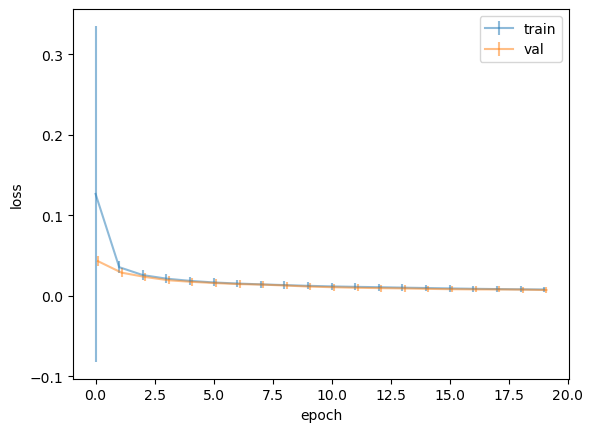

In [131]:
cnn.plot_epochs(odata['epochs'])

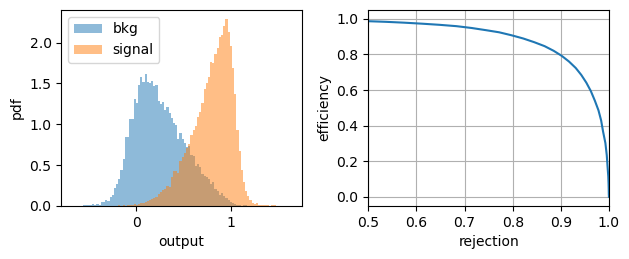

In [147]:
cnn.plot_roc(odata['y'], odata['yp'], 0.5)

In [148]:
def plot_event(idata, odata, ievt = -1):
    i0   = odata['index'][0]
    size = odata['index'][1] - i0
    ievt = int(np.random.choice(size, 1)) if ievt == -1 else ievt
    kevt = i0 + ievt
    print('event ', kevt)
    y0   = idata.y[kevt]
    yt0  = odata['y'][ievt]
    ytp  = odata['yp'][ievt]
    print('target test      ', int(y0))
    print('target test      ', int(yt0))
    print('target test pred ', float(ytp))
    dp.plot_imgs(idata.xdic, kevt, ['ecount',])
    print('total esum       ', np.sum(idata.xdic['esum'][kevt]))
    dp.plot_imgs(idata.zdic, kevt, ['seg', 'ext'])
    return

event  197088
target test       1
target test       1
target test pred  0.952444314956665
total esum        1.0


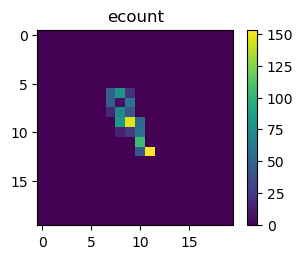

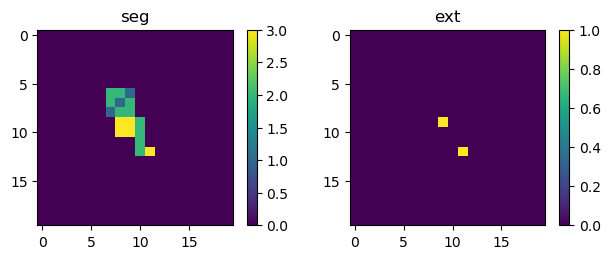

<Figure size 640x480 with 0 Axes>

In [156]:
plot_event(idata, odata)